# Lab 5: KNN

In this assignment, we will learn the KNN model.

First, please study the given example, which uses the KNN model for the breast cancer classification task. In this example, you will learn how to preprocess data, how to train the model, and how to evaluate the model.

Based on the given example, your task is to use the KNN model to predict the presence of heart disease.


## 1. Example

### 1.1 Load the breast cancer data

Here, we use the [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) dataset in sklearn. It is a binary classification dataset. Each sample has 30 numerical features, which can be found in [7.1.7](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

X, y = datasets.load_breast_cancer(return_X_y=True)
print("#samples: {}, #features: {}".format(X.shape[0], X.shape[1]))

#samples: 569, #features: 30


### 1.2 Split the data into two subsets and normalize the features of samples

Here, we use 69 samples as the testing set and use the remained samples to train the logistic regression model. 

In [2]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)


train_val: 500, test: 69


### 1.3 Train the KNN model and select the hyperparameter with cross-validation

Here, we use cross-validation to select the hyperparameter $K$

In [3]:
k_range = range(1, 5)
param_grid = dict(n_neighbors=k_range)

clf_knn =  KNeighborsClassifier(n_neighbors=1)

grid = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_val, y_train_val)

print(grid.best_score_)
print(grid.best_params_)

0.9640000000000001
{'n_neighbors': 4}


### 1.4 Evaluate the learned model

After getting the best hyperparameter $K$,  we evaluate this  model on the testing set. 

In [4]:
clf_knn =  KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
clf_knn.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf_knn.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 0.971, recall: 0.975, precision: 0.975, f1: 0.975,


## 2. Task

Here, we use the [heart disease](./heart.csv) dataset. Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

The last column refers to the presence of heart disease in the patient.

The task is to predict whether a person has the heart disease. Here, you can use your code in Lab04 for Task 2.1 and Task 2.2. 

In [5]:
# importing the necessary modules
import pandas as pd                 # for the dataframe
import math                         # for ceiling function
import matplotlib.pyplot as plt     # for various plots
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# constants
DATASET_FILENAME = r'heart.csv'     # filename of the dataset input
SEED = 42                           # randomizer for sampling, e.g., train, test data
MIN_SPARSE_P = 0.50                 # the minimum rate missing of a sparse feature
P_TEST = 0.2                        # proportion of testing data

### 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)


In [7]:
# load the heart disease dataset
df = pd.read_csv(DATASET_FILENAME)
N_SAMPS, N_FEATS = df.shape
print("# samples = {}".format(N_SAMPS))
print("# features = {}".format(N_FEATS))

# print some basic information about the dataset
print('\n===data frame information===')
df.info()

# print its parameters
print('\n===data frame parameters===')
df.describe()

# samples = 303
# features = 14

===data frame information===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

===data frame parameters===


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


From `df.info()`, we see that all of the features are numerical. Additionally, there are few examples $303 \leq 1000$. So we can inspect directly. Additionally, none are missing.

This can be more clearly demonstrated by finding the missing values.

In [8]:
# calculate the number of missing values
n_missing = df.isnull().sum()
# calculate the rate
p_missing = n_missing/df.shape[0]

print(r'===# missing values per column===')
print(n_missing)
print()
print(r'===# missing values per column===')
print(p_missing)

# remove any sparse features
df = df.drop(df.columns[p_missing > MIN_SPARSE_P], axis = 1)

===# missing values per column===
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

===# missing values per column===
age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64


We can clearly see that there are no missing values now. However, let's look at the distributions of each feature.

===histogram of age===
min	 29
25%	 47.5
75%	 61.0
iqr	 13.5
max	 77
range	 48
width	 4.019908994408628
# bins	 12


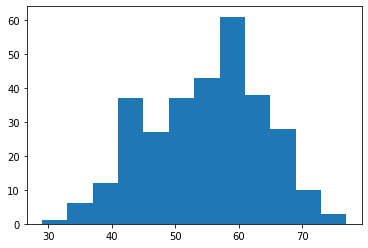


===histogram of sex===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


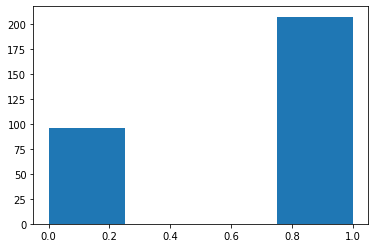


===histogram of cp===
min	 0
25%	 0.0
75%	 2.0
iqr	 2.0
max	 3
range	 3
width	 0.5955420732457227
# bins	 6


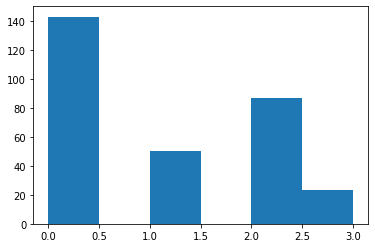


===histogram of trestbps===
min	 94
25%	 120.0
75%	 140.0
iqr	 20.0
max	 200
range	 106
width	 5.9554207324572275
# bins	 18


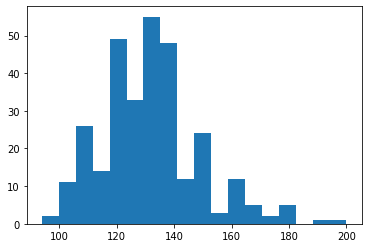


===histogram of chol===
min	 126
25%	 211.0
75%	 274.5
iqr	 63.5
max	 564
range	 438
width	 18.908460825551696
# bins	 24


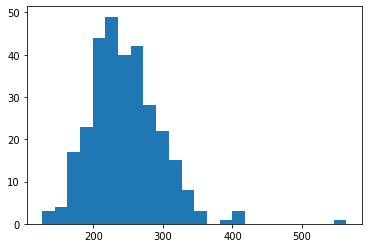


===histogram of fbs===
min	 0
25%	 0.0
75%	 0.0
iqr	 0.0
max	 1
range	 1
width	 0.5
# bins	 2


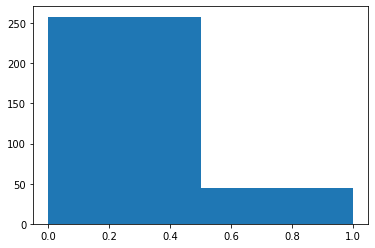


===histogram of restecg===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 2
range	 2
width	 0.29777103662286136
# bins	 7


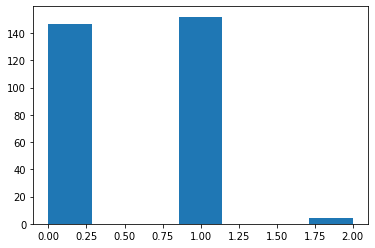


===histogram of thalach===
min	 71
25%	 133.5
75%	 166.0
iqr	 32.5
max	 202
range	 131
width	 9.677558690242995
# bins	 14


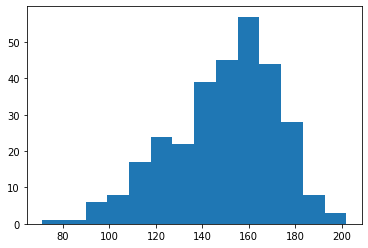


===histogram of exang===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


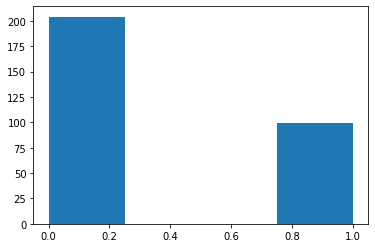


===histogram of oldpeak===
min	 0.0
25%	 0.0
75%	 1.6
iqr	 1.6
max	 6.2
range	 6.2
width	 0.4764336585965782
# bins	 14


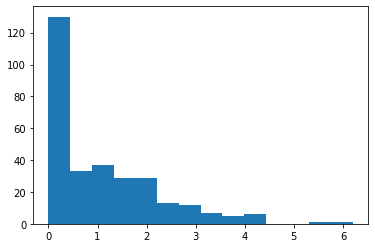


===histogram of slope===
min	 0
25%	 1.0
75%	 2.0
iqr	 1.0
max	 2
range	 2
width	 0.29777103662286136
# bins	 7


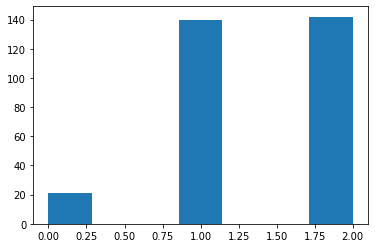


===histogram of ca===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 4
range	 4
width	 0.29777103662286136
# bins	 14


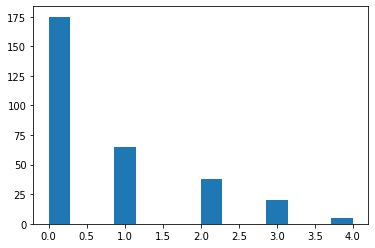


===histogram of thal===
min	 0
25%	 2.0
75%	 3.0
iqr	 1.0
max	 3
range	 3
width	 0.29777103662286136
# bins	 11


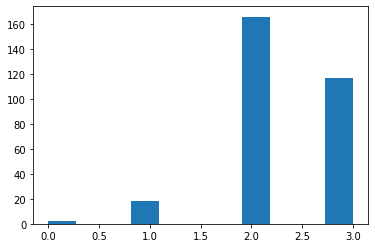


===histogram of target===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


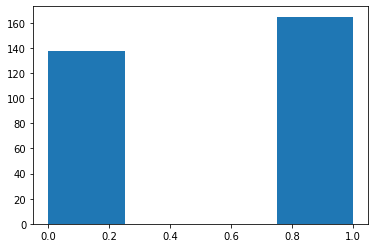

In [9]:
# loop through the features (all numerical)
for column in df.columns:
    # find the range
    min_val = df[column].min()
    max_val = df[column].max()
    range_val = max_val - min_val
    # find the interquartile range
    p25, p75 = (df[column].quantile(q=q) for q in (0.25, 0.75))
    iqr = p75 - p25
    # calculate the bin width
    # using Freedman–Diaconis' choice
    n = df[column].shape[0]
    width = (2 * iqr * (n**(-1/3)))
    # calculate the number of bins
    # if ZERO IQR, use 2 bins
    if (iqr):
        n_bins = math.ceil(range_val/width)
    else:
        n_bins = 2
        width = range_val/n_bins
    # end if (iqr)
    # print the parameters we calculated
    print(fr"===histogram of {column}===")
    print('min\t', min_val)
    print('25%\t', p25)
    print('75%\t', p75)
    print('iqr\t', iqr)
    print('max\t', max_val)
    print('range\t', range_val)
    print('width\t', width)
    print('# bins\t', n_bins)
    # plot for this feature
    plt.hist(df[column].values, n_bins)
    # place the plot here
    plt.show()
    print()
# next column

This time, we had to deal with an $I\!Q\!R = 0$. In that case, I assumed $k := 2$ bins and bin width $h \approx: \frac{\max\{X\} - \min\{X\}}k$.

We can see that
* the label `[13]` "target" is a non-long tail distribution.
* the `[0]` age, `[1]` sex, `[2]` chest pain, `[3]` resting BPS, `[4]` cholesterol, `[5]` fasting blood sugar, `[6]` resting ECG, `[7]` maximum `thal` achieved, `[8]` exercise-induced angina, `[9]` `oldpeak`, `[10]` slope of peak, `[11]` number of major vessel, and `[12]` `thal` are long-tail distributions.

In [10]:
cols = df.columns
# all numerical columns
i_cols = set(range(cols.shape[0]))

# We can see that
# * the label `[13]` "target" is a non-long tail distribution.
i_non_longtails = [13]
# * the `[0]` age, `[1]` sex, `[2]` chest pain, `[3]` resting BPS,
#   `[4]` cholesterol, `[5]` fasting blood sugar, `[6]` resting ECG,
#   `[7]` maximum `thal` achieved, `[8]` exercise-induced angina,
#   `[9]` `oldpeak`, `[10]` slope of peak, `[11]` number of major
#   vessel, and `[12]` `thal` are long-tail distributions.
i_longtails = list(i_cols - set(i_non_longtails))

# split the long tail distributions and non-long tail distributions
df_longtail_cols = cols[list(i_longtails)]
df_non_longtail_cols = cols[i_non_longtails]

# print the distribution by type
print(r'===columns by distribution===')
print(r"long tails: {}".format(df_longtail_cols))
print(r"non-long tails: {}".format(df_non_longtail_cols))

# replace missing long tails with medians
for column in df_longtail_cols:
    median = df[column].median()
    df[column] = df[column].fillna(median)
# next lt_column in df_longtail_cols

# for missing non-long tails, replace with mean
for column in df_non_longtail_cols:
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)
# next column in df_non_longtail_cols

# confirm that there are no missing values
print(r'===Any still missing?===')
print(df.isna().sum() != 0)

===columns by distribution===
long tails: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
non-long tails: Index(['target'], dtype='object')
===Any still missing?===
age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool


We check the correlations of each pair of features to find redundant features that can be eliminited.

In [11]:
# calculate the correlation matrix
hcorr = df.corr()
# display using gradients
hcorr.style.background_gradient()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


There is no strong correlation between any pair of features.

To see if target will be balanced, let us view it more clearly using the bar plot.

target
1    165
0    138
Name: target, dtype: int64
rate of difference = 0.1782178217821782


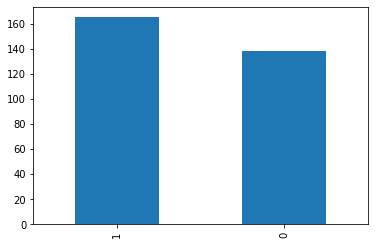

In [12]:
# find the label and its label counts
label = df.columns[-1]
label_counts = df[label].value_counts()
r_diff = 2*abs(label_counts[0] - label_counts[1])/(label_counts[0] + label_counts[1])

# print and bar plot of the label
print(label)
print(label_counts)
print(r"rate of difference = {}".format(r_diff))
label_counts.plot(kind=r'bar')
plt.show()

The relative rate of difference is about $18\,\%$, which is significant. Thus, the data is somewhat imbalanced.

### 2.2 Split the data into two subsets and normalize the features of samples

* Split the dataset into the train_val set and testing set. 
* Normalize features

In [13]:
# split X, y
y = df[label].values
Xdf = df.drop(label, axis=1)
X = Xdf.values
# split training, testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=P_TEST, random_state=SEED)
N_TRAIN = X_train.shape[0]
N_TEST = X_test.shape[0]
print(r'# samples for training =', N_TRAIN)
print(r'# samples for testing =', N_TEST)

# samples for training = 242
# samples for testing = 61


Next normalize. Start by finding outliers ($1.5\,I\!Q\!R$s outside of the range $[Q_1, Q_3]$) on $\mathbf{x}$'s data frame.

In [14]:
# find the interquartile range
q1, q3 = (Xdf.quantile(q=q) for q in np.array([1, 3])*0.25)
iqr = q3 - q1
# calculate limits of the outlier
inlier_min = (q1 - 1.5*iqr)
inlier_max = (q3 + 1.5*iqr)
# find any values out of range
outliers = ((Xdf < inlier_min) | (Xdf > inlier_max))
# print the limits
print(r'===outlier lower limit===')
print(inlier_min)
print()
print(r'===outlier upper limit===')
print(inlier_max)
print()
# print whether any outliers
print(r'===has outliers?===')
print(outliers.any())

===outlier lower limit===
age          27.25
sex          -1.50
cp           -3.00
trestbps     90.00
chol        115.75
fbs           0.00
restecg      -1.50
thalach      84.75
exang        -1.50
oldpeak      -2.40
slope        -0.50
ca           -1.50
thal          0.50
dtype: float64

===outlier upper limit===
age          81.25
sex           2.50
cp            5.00
trestbps    170.00
chol        369.75
fbs           0.00
restecg       2.50
thalach     214.75
exang         2.50
oldpeak       4.00
slope         3.50
ca            2.50
thal          4.50
dtype: float64

===has outliers?===
age         False
sex         False
cp          False
trestbps     True
chol         True
fbs          True
restecg     False
thalach      True
exang       False
oldpeak      True
slope       False
ca           True
thal         True
dtype: bool


Well, the resting BPS, cholesterol, fasting blood sugar, maximum `thal` achieved, `oldpeak`, number of major blood vessels, and `thal` each have outliers. Since at least 1 column has outliers, we will use standardization (Z-score normalization), rather than min-max normalization.

In [15]:
# standardization
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

# find the z-scores, replacing X_train, X_test
X_train, X_test = ((X - means)/stds for X in (X_train, X_test))

# print the statistics (sampled) to verify information
print(r'===standardized X_train statistics===')
print(pd.DataFrame(X_train).describe())

===standardized X_train statistics===
                 0             1             2             3             4   \
count  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02   
mean  -3.303143e-17 -1.761676e-16 -2.936127e-17  7.083406e-16 -2.715917e-16   
std    1.002073e+00  1.002073e+00  1.002073e+00  1.002073e+00  1.002073e+00   
min   -2.772079e+00 -1.384075e+00 -9.718909e-01 -2.165023e+00 -2.198732e+00   
25%   -7.035917e-01 -1.384075e+00 -9.718909e-01 -6.168556e-01 -6.613293e-01   
50%    1.129166e-01  7.225044e-01  8.099091e-03 -2.140663e-02 -1.393717e-01   
75%    7.116893e-01  7.225044e-01  9.880891e-01  5.740423e-01  5.296831e-01   
max    2.453574e+00  7.225044e-01  1.968079e+00  3.670377e+00  6.019728e+00   

                 5             6             7             8             9   \
count  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02   
mean   2.202095e-17 -8.808381e-17  3.101284e-16  3.303143e-17 -2.202095e-16   
std    1.0020

We can verify the expected mean $\bar{x} \approx 0$ and standard deviation $S_{\mathbf{X}} \approx 1$ for each column by inspection.

These all have been verified by inspection to hold true for the heart disease data from Lab 04.

### 2.3 Train the KNN model and select the hyperparameter with cross-validation


* Use the 5-fold cross-validation to select the hyperparameter $K$.
* Search $K$ from $\{1, 2, 3, 4, 5\}$


In [21]:
ks = [1, 2, 3, 4, 5]            # set of number of neighbors to search

# loop through the Ks
for k in ks:
    # train the corresponding KNN classifier
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train, y_train)

    # predict according to KNN
    y_test_pred = clf_knn.predict(X_test)
# next k

### 2.4 Evaluate the learned model

* Report the prediction accuracy, recall, precision, and F1 score.

* Note that you should implement the code for these metrics by yourself. Please do NOT use the built-in function in sklearn. 

In [17]:
## your code